In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D,Conv1D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten
from keras.layers.pooling import GlobalMaxPooling2D,GlobalMaxPooling1D
from keras.models import Model,Sequential
from keras.layers.advanced_activations import PReLU
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [2]:
from keras import __version__ as keras_version
print('Keras version: {}'.format(keras_version))

Keras version: 2.0.3


In [3]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec.model'
vocab_path='model/word2vec_vocab.json'
embeddings_path='model/embeddings.npz'
full_features_filename = '../data/features_full_plusnouns_pluspuidthreshpluss2vsimscore.csv'

In [4]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [5]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [6]:
feature_df.columns

Index(['id', 'product_idx', 'product_uid', 'relevance', 'relevance_int',
       'search_term', 'color_exist', 'brand_exist', 'wm_product_description',
       'wm_product_title', 'wm_product_brand', 'wm_attr_json',
       'Word2VecQueryExpansion', 'tfidf_product_title', 'tfidf_product_brand',
       'tfidf_product_description', 'tfidf_attr_json',
       'tfidf_expanded_product_title', 'tfidf_expanded_product_brand',
       'tfidf_expanded_product_description', 'tfidf_expanded_attr_json',
       'doc2vec_search_term_vector', 'doc2vec_product_title_vector',
       'doc2vec_product_title', 'doc2vec_product_brand_vector',
       'doc2vec_product_brand', 'doc2vec_product_description_vector',
       'doc2vec_product_description', 'doc2vec_attr_json_vector',
       'doc2vec_attr_json', 'doc2vec_Word2VecQueryExpansion_vector',
       'doc2vec_expanded_product_title', 'doc2vec_expanded_product_brand',
       'doc2vec_expanded_product_description', 'doc2vec_expanded_attr_json',
       'bm25', 'bm

In [7]:
feature_df.shape

(240758, 49)

In [8]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,3,2,1.0,1.0,0.027027,1,0.396952,0.110782,0.396952,0.110782
1,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,3,2,1.0,1.0,0.027027,1,0.111254,0.062794,0.111254,0.062794
2,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,3,2,0.0,0.0,0.000000,1,0.305971,0.155425,0.305971,0.155425
3,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,3,2,0.0,0.0,0.000000,1,0.093536,0.093076,0.093536,0.093076
4,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,4,1,8.0,3.0,0.068966,1,0.355857,0.149728,0.355857,0.149728
5,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,4,1,8.0,3.0,0.068966,1,0.268002,0.163241,0.268002,0.163241
6,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,1,3,4.0,2.0,0.080000,1,0.322412,0.114341,0.322412,0.114341
7,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,1,3,4.0,2.0,0.080000,1,0.338932,0.115508,0.338932,0.115508
8,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,1,2,12.0,3.0,0.240000,1,0.030452,0.012000,0.030452,0.012000
9,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,1,2,12.0,3.0,0.240000,1,0.342431,0.153442,0.342431,0.153442


In [9]:
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
print(soln_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 3 columns):
id           166693 non-null int64
relevance    166693 non-null float64
Usage        166693 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ MB
None


In [10]:
dp = DataPreprocessing()
feature_test_df=feature_df.copy()
feature_test_df.pop('relevance')
test_private_df = dp.getGoldTestSet(feature_test_df, soln_df,
                                    testsetoption='Private')  # ,savepath='../data/test_private_gold.csv')

In [11]:
test_private_df

,id,product_idx,product_uid,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,wm_product_brand,...,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,relevance
79104,5,"Int64Index([0], dtype='int64')",100001,NaN,simpson sku abl,0,0,1.298524,1.087237,1.324432,...,3,2.0,1.0,0.054054,1,0.012246,0.007444,0.012246,0.007444,2.33
79105,5,"Int64Index([0], dtype='int64')",100001,NaN,simpson sku abl,0,0,1.298524,1.087237,1.324432,...,3,2.0,1.0,0.054054,1,0.173348,0.061607,0.173348,0.061607,2.33
79106,6,"Int64Index([0], dtype='int64')",100001,NaN,simpson strong tie,0,0,1.244847,0.755408,1.113699,...,3,6.0,2.0,0.162162,1,0.450305,0.152107,0.450305,0.152107,2.67
79107,6,"Int64Index([0], dtype='int64')",100001,NaN,simpson strong tie,0,0,1.244847,0.755408,1.113699,...,3,6.0,2.0,0.162162,1,0.327519,0.122193,0.327519,0.122193,2.67
79112,10,"Int64Index([54667], dtype='int64')",100003,NaN,bath shower kit,0,0,1.292881,1.106092,1.385708,...,3,6.0,3.0,0.153846,1,-0.004371,-0.007341,-0.004371,-0.007341,2.67
79113,10,"Int64Index([54667], dtype='int64')",100003,NaN,bath shower kit,0,0,1.292881,1.106092,1.385708,...,3,6.0,3.0,0.153846,1,0.297397,0.108830,0.297397,0.108830,2.67
79122,15,"Int64Index([2], dtype='int64')",100005,NaN,delta ashland shower faucet,0,1,1.221584,0.932011,1.285776,...,4,14.0,3.0,0.280000,1,0.241557,0.119415,0.241557,0.119415,2.67
79123,15,"Int64Index([2], dtype='int64')",100005,NaN,delta ashland shower faucet,0,1,1.221584,0.932011,1.285776,...,4,14.0,3.0,0.280000,1,0.217235,0.102798,0.217235,0.102798,2.67
79128,24,"Int64Index([54669], dtype='int64')",100008,NaN,self tap screw,0,0,1.189219,1.079132,1.384036,...,3,4.0,2.0,0.054054,1,0.259859,0.150699,0.259859,0.150699,3.00
79129,24,"Int64Index([54669], dtype='int64')",100008,NaN,self tap screw,0,0,1.189219,1.079132,1.384036,...,3,4.0,2.0,0.054054,1,-0.005698,0.014031,-0.005698,0.014031,3.00


In [12]:
feature_df.loc[feature_df.id.isin(test_private_df.id), ['relevance']] = test_private_df[['relevance']]


In [13]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,brand_exist,wm_product_description,wm_product_title,...,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,3,2,1.0,1.0,0.027027,1,0.396952,0.110782,0.396952,0.110782
1,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,1.298530,1.065446,...,3,2,1.0,1.0,0.027027,1,0.111254,0.062794,0.111254,0.062794
2,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,3,2,0.0,0.0,0.000000,1,0.305971,0.155425,0.305971,0.155425
3,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,1.328475,1.308964,...,3,2,0.0,0.0,0.000000,1,0.093536,0.093076,0.093536,0.093076
4,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,4,1,8.0,3.0,0.068966,1,0.355857,0.149728,0.355857,0.149728
5,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,1.296529,1.195929,...,4,1,8.0,3.0,0.068966,1,0.268002,0.163241,0.268002,0.163241
6,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,1,3,4.0,2.0,0.080000,1,0.322412,0.114341,0.322412,0.114341
7,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,1.291264,1.195568,...,1,3,4.0,2.0,0.080000,1,0.338932,0.115508,0.338932,0.115508
8,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,1,2,12.0,3.0,0.240000,1,0.030452,0.012000,0.030452,0.012000
9,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,1.261110,1.053995,...,1,2,12.0,3.0,0.240000,1,0.342431,0.153442,0.342431,0.153442


In [14]:
feature_rescale_df = feature_df.copy() #feature_df[:74067].copy()
# # Must drop these columns for OrdinalRegression
feature_rescale_df.drop('id', axis=1, inplace=True)
feature_rescale_df.drop('search_term', axis=1, inplace=True)
feature_rescale_df.drop('product_uid', axis=1, inplace=True)
feature_rescale_df.drop('relevance_int', axis=1, inplace=True)
feature_rescale_df.drop('product_idx', axis=1, inplace=True)
feature_rescale_df.drop('Word2VecQueryExpansion', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_search_term_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_title_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_brand_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)
feature_rescale_df.drop('wm_product_brand', axis=1, inplace=True)

In [15]:
feature_rescale_df.columns

Index(['relevance', 'color_exist', 'brand_exist', 'wm_product_description',
       'wm_product_title', 'wm_attr_json', 'tfidf_product_title',
       'tfidf_product_brand', 'tfidf_product_description', 'tfidf_attr_json',
       'tfidf_expanded_product_title', 'tfidf_expanded_product_brand',
       'tfidf_expanded_product_description', 'tfidf_expanded_attr_json',
       'doc2vec_product_title', 'doc2vec_product_brand',
       'doc2vec_product_description', 'doc2vec_attr_json',
       'doc2vec_expanded_product_title', 'doc2vec_expanded_product_brand',
       'doc2vec_expanded_product_description', 'doc2vec_expanded_attr_json',
       'bm25', 'bm25expandedquery', 'len_product_title',
       'len_product_description', 'len_brand', 'len_search_term',
       'noun_overlap_counts', 'noun_uniq_overlap_counts',
       'noun_overlap_ratios', 'product_uid_threshold',
       'sense2vec_all_simscore', 'sense2vec_keeptag_simscore',
       'sense2vec_uidfact_all_simscore', 'sense2vec_uidfact_keeptag_s

In [16]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore
0,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,3,2,1.0,1.0,0.027027,1,0.396952,0.110782,0.396952,0.110782
1,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,3,2,1.0,1.0,0.027027,1,0.111254,0.062794,0.111254,0.062794
2,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,3,2,0.0,0.0,0.000000,1,0.305971,0.155425,0.305971,0.155425
3,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,3,2,0.0,0.0,0.000000,1,0.093536,0.093076,0.093536,0.093076
4,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,4,1,8.0,3.0,0.068966,1,0.355857,0.149728,0.355857,0.149728
5,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,4,1,8.0,3.0,0.068966,1,0.268002,0.163241,0.268002,0.163241
6,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,1,3,4.0,2.0,0.080000,1,0.322412,0.114341,0.322412,0.114341
7,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,1,3,4.0,2.0,0.080000,1,0.338932,0.115508,0.338932,0.115508
8,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,1,2,12.0,3.0,0.240000,1,0.030452,0.012000,0.030452,0.012000
9,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,1,2,12.0,3.0,0.240000,1,0.342431,0.153442,0.342431,0.153442


# Rescale values

In [17]:
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan)
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan).dropna()

In [18]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore
0,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,3,2,1.0,1.0,0.027027,1,0.396952,0.110782,0.396952,0.110782
1,3.00,0,0,1.298530,1.065446,1.289860,0.302807,0.000000,0.145313,0.089007,...,3,2,1.0,1.0,0.027027,1,0.111254,0.062794,0.111254,0.062794
2,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,3,2,0.0,0.0,0.000000,1,0.305971,0.155425,0.305971,0.155425
3,2.50,0,0,1.328475,1.308964,1.293272,0.000000,0.000000,0.000000,0.000000,...,3,2,0.0,0.0,0.000000,1,0.093536,0.093076,0.093536,0.093076
4,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,4,1,8.0,3.0,0.068966,1,0.355857,0.149728,0.355857,0.149728
5,3.00,0,0,1.296529,1.195929,1.299271,0.240642,0.000000,0.201082,0.167435,...,4,1,8.0,3.0,0.068966,1,0.268002,0.163241,0.268002,0.163241
6,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,1,3,4.0,2.0,0.080000,1,0.322412,0.114341,0.322412,0.114341
7,2.33,0,0,1.291264,1.195568,1.300242,0.123153,0.000000,0.055939,0.122771,...,1,3,4.0,2.0,0.080000,1,0.338932,0.115508,0.338932,0.115508
8,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,1,2,12.0,3.0,0.240000,1,0.030452,0.012000,0.030452,0.012000
9,2.67,0,0,1.261110,1.053995,1.250205,0.371544,0.000000,0.140635,0.210637,...,1,2,12.0,3.0,0.240000,1,0.342431,0.153442,0.342431,0.153442


In [19]:
#https://www.quora.com/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together
def rescale_bounded_cont_feat(x,xmax,xmin):
    x_new = (2*x-xmax-xmin)/(xmax-xmin)
    return x_new

def rescale_cont_feat(x,xmean,xstd):
    x_new = (x-xmean)/xstd
    return x_new

for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
#         if col == 'relevance':
#             print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())
#         feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_cont_feat, \
#                                       args=(feature_rescale_df[col].mean(),feature_rescale_df[col].std()))
        feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_bounded_cont_feat, \
                                      args=(feature_rescale_df[col].max(),feature_rescale_df[col].min()))
##         if np.isinf(feature_rescale_df[col].max()):
##             print("is max inf")

==== relevance
13
count    160317.000000
mean          2.433678
std           0.528564
min           1.000000
25%           2.000000
50%           2.670000
75%           3.000000
max           3.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== brand_exist
binary
==== wm_product_description
106032
count    160317.000000
mean          1.233410
std           0.065748
min           0.699152
25%           1.197073
50%           1.240259
75%           1.277419
max           1.419445
Name: wm_product_description, dtype: float64
==== wm_product_title
106695
count    160317.000000
mean          1.056141
std           0.172170
min           0.000000
25%           0.957323
50%           1.076275
75%           1.177083
max           1.419102
Name: wm_product_title, dtype: float64
==== wm_attr_json
85665
count    160317.000000
mean          1.284542
std           0.073499
min           0.670739
25%           1.241257
50%           1.286081
75%           1.337045
max           1.4

In [20]:
for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
        if col == 'relevance':
            print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())

==== relevance
leave relevance
13
count    160317.000000
mean          0.433678
std           0.528564
min          -1.000000
25%           0.000000
50%           0.670000
75%           1.000000
max           1.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== brand_exist
binary
==== wm_product_description
106032
count    160317.000000
mean          0.483449
std           0.182560
min          -1.000000
25%           0.382552
50%           0.502466
75%           0.605646
max           1.000000
Name: wm_product_description, dtype: float64
==== wm_product_title
106695
count    160317.000000
mean          0.488464
std           0.242646
min          -1.000000
25%           0.349196
50%           0.516840
75%           0.658913
max           1.000000
Name: wm_product_title, dtype: float64
==== wm_attr_json
85665
count    160317.000000
mean          0.525988
std           0.182727
min          -1.000000
25%           0.418377
50%           0.529814
75%           0.656519
m

In [21]:
feature_rescale_df

,relevance,color_exist,brand_exist,wm_product_description,wm_product_title,wm_attr_json,tfidf_product_title,tfidf_product_brand,tfidf_product_description,tfidf_attr_json,...,len_brand,len_search_term,noun_overlap_counts,noun_uniq_overlap_counts,noun_overlap_ratios,product_uid_threshold,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore
0,1.00,0,0,0.664262,0.501578,0.539211,-0.394386,-1.000000,-0.615724,-0.755275,...,-0.2,-0.875,-0.990244,-0.894737,-0.983466,1,0.546198,-0.171030,0.615192,-0.091574
1,1.00,0,0,0.664262,0.501578,0.539211,-0.394386,-1.000000,-0.615724,-0.755275,...,-0.2,-0.875,-0.990244,-0.894737,-0.983466,1,-0.099891,-0.300251,-0.059727,-0.239931
2,0.50,0,0,0.747409,0.844779,0.547692,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.2,-0.875,-1.000000,-1.000000,-1.000000,1,0.340451,-0.050815,0.400264,0.046444
3,0.50,0,0,0.747409,0.844779,0.547692,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.2,-0.875,-1.000000,-1.000000,-1.000000,1,-0.139960,-0.218709,-0.101583,-0.146313
4,1.00,0,0,0.658708,0.685474,0.562608,-0.518716,-1.000000,-0.468244,-0.539637,...,0.2,-1.000,-0.921951,-0.684211,-0.957809,1,0.453265,-0.066155,0.518112,0.028832
5,1.00,0,0,0.658708,0.685474,0.562608,-0.518716,-1.000000,-0.468244,-0.539637,...,0.2,-1.000,-0.921951,-0.684211,-0.957809,1,0.254585,-0.029768,0.310567,0.070607
6,0.33,0,0,0.644088,0.684965,0.565021,-0.753694,-1.000000,-0.852071,-0.662440,...,-1.0,-0.750,-0.960976,-0.789474,-0.951059,1,0.377631,-0.161446,0.439103,-0.080571
7,0.33,0,0,0.644088,0.684965,0.565021,-0.753694,-1.000000,-0.852071,-0.662440,...,-1.0,-0.750,-0.960976,-0.789474,-0.951059,1,0.414988,-0.158302,0.478128,-0.076961
8,0.67,0,0,0.560361,0.485440,0.440624,-0.256911,-1.000000,-0.628096,-0.420852,...,-1.0,-0.875,-0.882927,-0.684211,-0.853176,1,-0.282620,-0.437028,-0.250609,-0.396963
9,0.67,0,0,0.560361,0.485440,0.440624,-0.256911,-1.000000,-0.628096,-0.420852,...,-1.0,-0.875,-0.882927,-0.684211,-0.853176,1,0.422902,-0.056155,0.486394,0.040313


# vectors

In [22]:
def convert_to_np_arr(vec_as_str,n_dims=100):
    vec = [float(re.sub('[\[\]]','',i)) for i in vec_as_str.split() if i != '[' and i != ']']
    #print(vec)
    #vec = np.asarray(vec)
    vec = np.array(vec)
    m_dims=int(len(vec)/n_dims)
    #print(m_dims)
    if m_dims == 1:
        vec = vec.reshape((n_dims))
    else:
        vec = vec.reshape((m_dims, n_dims))
    #vec=np.squeeze(vec)
    return vec.tolist()

In [23]:
a = feature_df.iloc[0:10]['doc2vec_search_term_vector'].apply(convert_to_np_arr)

In [24]:
b=[]
for v in a.values:
    b+=[v]
c=np.array(b)   
c.shape

(10, 100)

In [25]:
# final=convert_to_np_arr(feature_df.iloc[0]['doc2vec_search_term_vector'],100)
# np.squeeze(final)
#feature_df.iloc[0]['doc2vec_search_term_vector']

In [26]:
feature_df['doc2vec_search_term_vector'] = feature_df['doc2vec_search_term_vector'].apply(convert_to_np_arr)

In [27]:
feature_df['doc2vec_product_title_vector'] = feature_df['doc2vec_product_title_vector'].apply(convert_to_np_arr)

In [28]:
feature_df['doc2vec_product_brand_vector'] = \
feature_df['doc2vec_product_brand_vector'].apply(convert_to_np_arr)

In [29]:
feature_df['doc2vec_product_description_vector'] = \
feature_df['doc2vec_product_description_vector'].apply(convert_to_np_arr)

In [30]:
feature_df['doc2vec_attr_json_vector'] = \
feature_df['doc2vec_attr_json_vector'].apply(convert_to_np_arr)

In [31]:
feature_df['doc2vec_Word2VecQueryExpansion_vector'] = \
feature_df['doc2vec_Word2VecQueryExpansion_vector'].apply(convert_to_np_arr)

In [32]:
feature_df.iloc[0]['doc2vec_product_title_vector']#.shape

[0.88364893,
 -0.0229548,
 -0.86971122,
 0.2491895,
 0.24953915,
 -0.19891015,
 -0.62637907,
 0.24735376,
 -0.02696783,
 -0.44262162,
 0.15812074,
 -0.08349536,
 0.1631892,
 0.68931061,
 -0.0647246,
 -0.10032325,
 0.20852223,
 0.01912345,
 0.39585462,
 0.41956559,
 -0.29631126,
 -0.01033811,
 -0.71332747,
 -0.87839919,
 -0.13718374,
 0.46151692,
 -0.34224674,
 0.15253833,
 -0.4637281,
 0.81758726,
 0.34329945,
 -0.0527522,
 0.47451109,
 0.31515947,
 -0.13701615,
 0.26214835,
 -0.12419374,
 -0.19488108,
 -1.01412034,
 0.44638425,
 -0.00629678,
 0.02270081,
 0.15648581,
 0.14591074,
 -0.43953893,
 0.64304507,
 -0.41440558,
 -0.25611523,
 0.73812127,
 0.12652887,
 0.62336755,
 -0.01699993,
 0.04272119,
 0.30516303,
 -0.49358135,
 -0.45945004,
 -0.6079554,
 0.11847479,
 0.01335187,
 0.11736247,
 0.02189387,
 0.03589836,
 0.24320659,
 -0.14858149,
 0.18477404,
 0.20867847,
 0.18608874,
 0.56080455,
 -0.24601381,
 0.20307569,
 0.53454196,
 -0.23699029,
 -0.14202628,
 0.26289755,
 -0.32814586

In [33]:
#feature_df['doc2vec_search_term_vector']
#feature_df['doc2vec_product_title_vector']
#feature_df['doc2vec_product_brand_vector']
# feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)
# feature_rescale_df.drop('wm_product_brand', axis=1, inplace=True)

In [34]:
feature_df[['doc2vec_search_term_vector','doc2vec_product_title_vector',\
           'doc2vec_product_brand_vector','doc2vec_product_description_vector',\
           'doc2vec_attr_json_vector','doc2vec_Word2VecQueryExpansion_vector']]

,doc2vec_search_term_vector,doc2vec_product_title_vector,doc2vec_product_brand_vector,doc2vec_product_description_vector,doc2vec_attr_json_vector,doc2vec_Word2VecQueryExpansion_vector
0,"[0.35046741, -0.21905822, -0.18392235, -0.4265...","[0.88364893, -0.0229548, -0.86971122, 0.249189...","[-0.00431272155, -0.00406582979, -0.0023834726...","[1.45625901, 1.97699928, -2.43561339, -0.63718...","[1.82501316, 2.01582122, 0.707585335, 1.741124...","[0.35046741, -0.21905822, -0.18392235, -0.4265..."
1,"[0.35046741, -0.21905822, -0.18392235, -0.4265...","[0.88364893, -0.0229548, -0.86971122, 0.249189...","[-0.00431272155, -0.00406582979, -0.0023834726...","[1.45625901, 1.97699928, -2.43561339, -0.63718...","[1.82501316, 2.01582122, 0.707585335, 1.741124...","[0.35046741, -0.21905822, -0.18392235, -0.4265..."
2,"[0.35868773, 0.07453699, 0.02654045, -0.317921...","[0.90943021, -0.04441905, -0.94266558, 0.21397...","[-0.00431272155, -0.00406582979, -0.0023834726...","[1.44547904, 2.23038101, -2.41784382, -0.55672...","[1.65835345, 2.1997726, 0.69156033, 1.87265778...","[0.35868773, 0.07453699, 0.02654045, -0.317921..."
3,"[0.35868773, 0.07453699, 0.02654045, -0.317921...","[0.90943021, -0.04441905, -0.94266558, 0.21397...","[-0.00431272155, -0.00406582979, -0.0023834726...","[1.44547904, 2.23038101, -2.41784382, -0.55672...","[1.65835345, 2.1997726, 0.69156033, 1.87265778...","[0.35868773, 0.07453699, 0.02654045, -0.317921..."
4,"[0.10810383, -0.02842659, -0.14235462, -0.0489...","[0.11359098, -0.06820592, -1.69272947, 0.60021...","[-0.00014669, 0.00074291, -0.00021471, 0.00437...","[-0.93054795, 1.16094613, -4.79884815, 2.02278...","[-0.44515941, -1.01213825, -1.3692919, 4.20704...","[0.10810383, -0.02842659, -0.14235462, -0.0489..."
5,"[0.10810383, -0.02842659, -0.14235462, -0.0489...","[0.11359098, -0.06820592, -1.69272947, 0.60021...","[-0.00014669, 0.00074291, -0.00021471, 0.00437...","[-0.93054795, 1.16094613, -4.79884815, 2.02278...","[-0.44515941, -1.01213825, -1.3692919, 4.20704...","[0.10810383, -0.02842659, -0.14235462, -0.0489..."
6,"[0.38372955, 0.03648806, -0.45118526, 0.173617...","[0.56182325, 0.28821036, -0.46710014, -0.25448...","[0.000739369367, 0.00331215025, 0.00284372084,...","[-0.99333686, 1.35560107, -1.79892254, 0.43698...","[0.176538244, -1.30180907, -0.752591193, 0.572...","[0.38372955, 0.03648806, -0.45118526, 0.173617..."
7,"[0.38372955, 0.03648806, -0.45118526, 0.173617...","[0.56182325, 0.28821036, -0.46710014, -0.25448...","[0.000739369367, 0.00331215025, 0.00284372084,...","[-0.99333686, 1.35560107, -1.79892254, 0.43698...","[0.176538244, -1.30180907, -0.752591193, 0.572...","[0.38372955, 0.03648806, -0.45118526, 0.173617..."
8,"[0.05758999, -0.04412973, -0.24035545, -0.0337...","[0.691048265, 0.244766876, -0.482372254, -0.24...","[0.000739369367, 0.00331215025, 0.00284372084,...","[-0.87843645, 1.44094491, -1.89829254, 0.48431...","[0.341319084, -1.11339962, -0.766011178, 0.576...","[0.20874012, 0.14365378, -0.33312002, -0.12168..."
9,"[0.05758999, -0.04412973, -0.24035545, -0.0337...","[0.691048265, 0.244766876, -0.482372254, -0.24...","[0.000739369367, 0.00331215025, 0.00284372084,...","[-0.87843645, 1.44094491, -1.89829254, 0.48431...","[0.341319084, -1.11339962, -0.766011178, 0.576...","[0.20874012, 0.14365378, -0.33312002, -0.12168..."


# input to model

In [35]:
feature_all_train_df = feature_rescale_df[:74067]
feature_test_df = feature_rescale_df[74067:]

In [36]:
feature_test_df.shape

(86250, 36)

In [37]:
# take 0.2 for validation
min_train_samples=int(len(feature_all_train_df)*0.8)
feature_train_df = feature_all_train_df.ix[np.random.choice(feature_all_train_df.index,min_train_samples,replace=False)]
feature_val_df = feature_all_train_df.ix[feature_all_train_df.index.difference(feature_train_df.index)]

In [38]:
print(len(feature_train_df))
print(len(feature_val_df))

59253
14814


In [39]:
y_train=feature_train_df['relevance'].as_matrix()
y_val=feature_val_df['relevance'].as_matrix()
y_test=feature_test_df['relevance'].as_matrix()

In [40]:
x_train=feature_train_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_val=feature_val_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_test=feature_test_df.drop('relevance', axis=1, inplace=False).as_matrix()

In [41]:
# #for conv1d
# x_train = np.expand_dims(x_train, axis=1)
# x_val = np.expand_dims(x_val, axis=1)
# x_test = np.expand_dims(x_test, axis=1)

In [42]:
x_train.shape

(59253, 35)

In [43]:
rowcnt=0
for row in x_train:
    if np.isnan(np.max(row)):
        print(rowcnt)
    rowcnt+=1

In [44]:
x_train[70]

array([ 0.        ,  0.        ,  0.10264813,  0.23754873,  0.294444  ,
       -0.24075916, -1.        ,  0.04161074, -0.02322995, -0.24075916,
       -1.        ,  0.04161074, -0.00424313,  0.01797361, -0.36744896,
        0.06683608,  0.13209013, -0.04310076, -0.41108754,  0.02515754,
        0.12501142, -1.        , -1.        , -0.64705882, -0.92299688,
       -0.6       , -0.75      , -0.92195122, -0.68421053, -0.83686275,
        1.        ,  0.48250335,  0.01985934,  0.33085435, -0.01282728])

In [45]:
feature_train_df.iloc[70]

relevance                               1.000000
color_exist                             0.000000
brand_exist                             0.000000
wm_product_description                  0.102648
wm_product_title                        0.237549
wm_attr_json                            0.294444
tfidf_product_title                    -0.240759
tfidf_product_brand                    -1.000000
tfidf_product_description               0.041611
tfidf_attr_json                        -0.023230
tfidf_expanded_product_title           -0.240759
tfidf_expanded_product_brand           -1.000000
tfidf_expanded_product_description      0.041611
tfidf_expanded_attr_json               -0.004243
doc2vec_product_title                   0.017974
doc2vec_product_brand                  -0.367449
doc2vec_product_description             0.066836
doc2vec_attr_json                       0.132090
doc2vec_expanded_product_title         -0.043101
doc2vec_expanded_product_brand         -0.411088
doc2vec_expanded_pro

# vector input to model

In [46]:
#a=feature_df.ix[feature_train_df.index,['doc2vec_search_term_vector']]

In [47]:
#a.values[0]

In [48]:
# b=[]
# for v in a.values:
#     b+=[v[0]]
# c=np.array(b)   
# c.shape

In [49]:
def vec_to_model_input(values):
    output_list=[]
    for v in values:
        output_list+=[v[0]]
    output_np=np.array(output_list)   
    print(output_np.shape)
    return output_np

In [50]:
#c=vec_to_model_input(a.values)
#c.shape

In [51]:
### #feature_df['doc2vec_search_term_vector']
### feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
x_query_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_search_term_vector']].values)
x_doc_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                          ['doc2vec_product_description_vector']].values)
x_query_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_search_term_vector']].values)
x_doc_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                           ['doc2vec_product_description_vector']].values)
x_query_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_search_term_vector']].values)
x_doc_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                            ['doc2vec_product_description_vector']].values)


(59253, 100)
(59253, 100)
(14814, 100)
(14814, 100)
(86250, 100)
(86250, 100)


In [52]:
### #feature_df['doc2vec_product_title_vector']
x_title_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_product_title_vector']].values)
x_title_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_product_title_vector']].values)
x_title_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_product_title_vector']].values)

(59253, 100)
(14814, 100)
(86250, 100)


In [53]:
####feature_df['doc2vec_product_brand_vector']
x_brand_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_product_brand_vector']].values)
x_brand_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_product_brand_vector']].values)
x_brand_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_product_brand_vector']].values)

(59253, 100)
(14814, 100)
(86250, 100)


In [54]:
####feature_df['doc2vec_attr_json_vector']
x_attr_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_attr_json_vector']].values)
x_attr_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_attr_json_vector']].values)
x_attr_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_attr_json_vector']].values)

(59253, 100)
(14814, 100)
(86250, 100)


In [55]:
##### doc2vec_Word2VecQueryExpansion_vector
x_queryexp_train=vec_to_model_input(feature_df.ix[feature_train_df.index,\
                                               ['doc2vec_Word2VecQueryExpansion_vector']].values)
x_queryexp_val=vec_to_model_input(feature_df.ix[feature_val_df.index,\
                                             ['doc2vec_Word2VecQueryExpansion_vector']].values)
x_queryexp_test=vec_to_model_input(feature_df.ix[feature_test_df.index,\
                                              ['doc2vec_Word2VecQueryExpansion_vector']].values)

(59253, 100)
(14814, 100)
(86250, 100)


In [56]:
###
#feature_df['doc2vec_product_title_vector']
#feature_df['doc2vec_product_brand_vector']
# feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)
# feature_rescale_df.drop('wm_product_brand', axis=1, inplace=True)

# define model


In [57]:
num_filters=100
query_filter_size_m=1
doc_filter_size_m=1

In [96]:
print('Building vector+feat model...')
input_query = Input(shape=(100,), dtype='float32', name='input_query')
input_doc = Input(shape=(100,), dtype='float32', name='input_doc')
input_title = Input(shape=(100,), dtype='float32', name='input_title')
input_brand = Input(shape=(100,), dtype='float32', name='input_brand')
input_attr = Input(shape=(100,), dtype='float32', name='input_attr')
input_queryexp = Input(shape=(100,), dtype='float32', name='input_queryexp')
input_feats = Input(shape=(x_train.shape[1],), dtype='float32', name='input_feats')

# ## convolution layer
# # include bias vector to result of each feature map
# # relu activation
# conv_query_output = Conv1D(filters=num_filters,
#             kernel_size=query_filter_size_m,
#             strides=1, 
#             padding='valid',#'same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
#             dilation_rate=1, 
#             activation='relu', 
#             use_bias=True, 
#             kernel_initializer='glorot_uniform', 
#             bias_initializer='glorot_uniform',#'zeros', 
#             kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#             kernel_constraint=None, bias_constraint=None)(input_query)

# conv_doc_output = Conv1D(filters=num_filters,
#             kernel_size=doc_filter_size_m,
#             strides=1, 
#             padding='valid',#'same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
#             dilation_rate=1, 
#             activation='relu', 
#             use_bias=True, 
#             kernel_initializer='glorot_uniform', 
#             bias_initializer='glorot_uniform',#'zeros', 
#             kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
#             kernel_constraint=None, bias_constraint=None)(input_doc)
# #TODO: do we want drop out here?

# ## Pooling layer
# # TODO: sliding Max Pooling instead of original Global Pooling?
# conv_query_output=GlobalMaxPooling1D()(conv_query_output)
# conv_doc_output=GlobalMaxPooling1D()(conv_doc_output)

##### query
## dense
conv_query_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_query)
conv_query_output = Dropout(0.1)(conv_query_output)

##### description/doc
## dense
conv_doc_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_doc)
conv_doc_output = Dropout(0.6)(conv_doc_output)

##### title
conv_title_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_title)
conv_title_output = Dropout(0.5)(conv_title_output)

##### brand
conv_brand_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_brand)
conv_brand_output = Dropout(0.5)(conv_brand_output)

##### attr 
conv_attr_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_attr)
conv_attr_output = Dropout(0.8)(conv_attr_output)

##### queryexp
conv_queryexp_output = Dense(32, activation='relu', use_bias=True, kernel_initializer='glorot_normal', \
               bias_initializer='glorot_normal', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_queryexp)
conv_queryexp_output = Dropout(0.8)(conv_queryexp_output)

# ## dense
# conv_feats_output = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_feats)
# conv_feats_output = Dropout(0.1)(conv_feats_output)


## cosine proximity
query_doc_dot_output = dot([conv_query_output,conv_doc_output], axes=(1,1), normalize=True)
query_title_dot_output = dot([conv_query_output,conv_title_output], axes=(1,1), normalize=True)
query_brand_dot_output = dot([conv_query_output,conv_brand_output], axes=(1,1), normalize=True)
query_attr_dot_output = dot([conv_query_output,conv_attr_output], axes=(1,1), normalize=True)


# #concatenate
# concat_output = concatenate([query_doc_dot_output,query_title_dot_output,\
#                              query_brand_dot_output,query_attr_dot_output,\
#                              input_feats], axis=-1)

## no vectors
concat_output = input_feats

# ## INPUT dense
# #model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
# output = Dense(64,
#                 #batch_input_shape=(None,x_train.shape[1]), 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(input_feats)
# output = Dropout(0.1)(output)


## dense
#model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
output = Dense(64,
                #batch_input_shape=(None,x_train.shape[1]), 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(concat_output)
output = Dropout(0.2)(output)

## dense
#model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
output = Dense(64,
                #batch_input_shape=(None,x_train.shape[1]), 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output)
output = Dropout(0.2)(output)

## dense
#activation='linear',
output = Dense(1, activation='tanh', use_bias=False, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output)

#model = Model([input_query,input_doc,input_exact_match], [conv_query_output,conv_doc_output])
model = Model([input_query,input_doc,input_title,input_brand,input_attr,input_queryexp,input_feats], [output])

model.summary()

Building vector+feat model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_feats (InputLayer)     (None, 35)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2304      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 64        
Total params: 6,528
Trainable params: 6,528
Non-trainable params: 0
____________________________________________

In [97]:
# print('Building model...')
# model = Sequential()
# # model.add(Conv1D(filters=128,
# #                         kernel_size=1,#6,
# #                         padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
# #                         activation='relu',
# #                         input_shape=(1, x_train.shape[2]),
# #                         kernel_initializer='lecun_uniform'
# #                         # lecun_uniform for both gets AUC: 0.865961 | (good split) AUC: 0.861570 with avg pool at end
# #                         # glorot_uniform for both gets AUC: 0.868817 | AUC: 0.863290  with avg pool at end
# #                         # he_uniform for both gets AUC: 0.868218 | AUC: 0.873585 with avg pool at end
# #                         ))

# # model.add(GlobalMaxPooling1D())

# ## dense
# # #model.add(Dense(128,activation='relu',batch_input_shape=(None,x_train.shape[1])))
# # model.add(Dense(128,batch_input_shape=(None,x_train.shape[1]), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
# #                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
# #                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# # model.add(Dropout(0.1))

# ## dense
# #model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
# model.add(Dense(64,
#                 #batch_input_shape=(None,x_train.shape[1]), 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# #model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.1))

# ## dense
# #model.add(Dense(64,activation='relu'))
# model.add(Dense(64, 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# #model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.1))

# ## dense
# #activation='linear',
# model.add(Dense(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

# model.summary()

In [98]:
optimizer = optimizers.Adam(lr=0.0001)
#optimizer = optimizers.adadelta()
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
# batch_size=64#2 #200
# model_fn='./model/dnn3.h5'
# # model_config_filepath='./model/cnn.json'
# # with open(model_config_filepath,'w') as f:
# #     json.dump(model.to_json(),f)

# print('Train...')
# ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
#                        save_best_only=True, save_weights_only=True,verbose=1)
# earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# hist=model.fit([x_train], [y_train],
#           batch_size=batch_size,
#           epochs=40,
#           shuffle=True,
#           verbose=2,
#           #validation_split=0.2,
#           validation_data=([x_val],y_val),
#           callbacks=[ckpt,earlystopper],
#          )

batch_size=64#2 #200
model_fn='./model/dnn3.h5'
# model_config_filepath='./model/cnn.json'
# with open(model_config_filepath,'w') as f:
#     json.dump(model.to_json(),f)

print('Train...')
ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                       save_best_only=True, save_weights_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
hist=model.fit([x_query_train,x_doc_train,x_title_train,x_brand_train,x_attr_train,
                x_queryexp_train,
                x_train], [y_train],
          batch_size=batch_size,
          epochs=40,
          shuffle=True,
          verbose=2,
          #validation_split=0.2,
          validation_data=([x_query_val,x_doc_val,x_title_val,x_brand_val,x_attr_val,
                            x_queryexp_val,
                            x_val],[y_val]),
          callbacks=[ckpt,earlystopper],
         )

Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/40
Epoch 00000: val_loss improved from inf to 0.22979, saving model to ./model/dnn3.h5
3s - loss: 0.2879 - acc: 0.2516 - val_loss: 0.2298 - val_acc: 0.3023
Epoch 2/40
Epoch 00001: val_loss improved from 0.22979 to 0.22567, saving model to ./model/dnn3.h5
3s - loss: 0.2468 - acc: 0.2890 - val_loss: 0.2257 - val_acc: 0.3053
Epoch 3/40
Epoch 00002: val_loss improved from 0.22567 to 0.22403, saving model to ./model/dnn3.h5
4s - loss: 0.2408 - acc: 0.2943 - val_loss: 0.2240 - val_acc: 0.3059
Epoch 4/40
Epoch 00003: val_loss improved from 0.22403 to 0.22262, saving model to ./model/dnn3.h5
3s - loss: 0.2370 - acc: 0.2969 - val_loss: 0.2226 - val_acc: 0.3061
Epoch 5/40
Epoch 00004: val_loss improved from 0.22262 to 0.22203, saving model to ./model/dnn3.h5
3s - loss: 0.2359 - acc: 0.2976 - val_loss: 0.2220 - val_acc: 0.3122
Epoch 6/40
Epoch 00005: val_loss improved from 0.22203 to 0.22091, saving model to ./model/dnn3.h5
3s - l

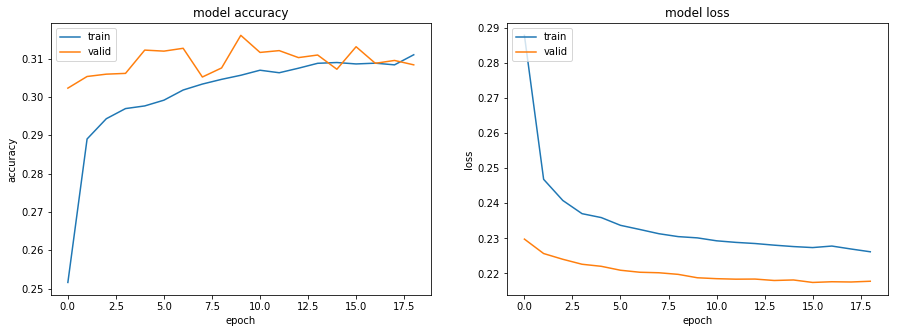

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [101]:
print("== Reload to best weights saved...")
model.load_weights(model_fn)

== Reload to best weights saved...


In [102]:
batch_size=64 #200
prediction=model.predict([x_query_train,x_doc_train,x_title_train,x_brand_train,x_attr_train,
                x_queryexp_train,
                          x_train],
          batch_size=batch_size,
         )

In [103]:
np.max(prediction)

0.89668578

In [104]:
np.min(prediction)

-0.29949519

In [105]:
np.max(y_train)

1.0

In [106]:
np.min(y_train)

-1.0

In [107]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_train, prediction)**0.5
print(RMSE)

0.471307894902


In [108]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
prediction_ori_scale = prediction+2
gold_ori_scale = y_train+2
RMSE = mean_squared_error(gold_ori_scale, prediction_ori_scale)**0.5
print(RMSE)

0.471307894682


In [109]:
np.min(gold_ori_scale)

1.0

# Predict

In [110]:
batch_size=64 #200
test_prediction=model.predict([x_query_test,x_doc_test,x_title_test,x_brand_test,x_attr_test,
                x_queryexp_test,
                               x_test],
          batch_size=batch_size,
         )

In [111]:
RMSE = mean_squared_error(y_test, test_prediction)**0.5
print(RMSE)

0.474630851923


In [112]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
test_prediction_ori_scale = test_prediction+2
test_gold_ori_scale = y_test+2
RMSE = mean_squared_error(test_gold_ori_scale, test_prediction_ori_scale)**0.5
print(RMSE)

0.474630852106


In [113]:
#0.4715 best with conv1d
#0.4739 best with full spec dense only 2x 64 hdim, 0.1 dropuot
#0.4730 best with full spec dense only 3x 64 hdim, 0.1 dropuot
#0.4725 best with full spec dense only 1x128 , 3x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x128 , 2x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot
#0.4741 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot

In [114]:
#vector alone
# 0.5232 0.2 dropout
# 0.5214 0.1 dropout